# Gesture Classification

This notebook is used to train classification models from csv dataset. 

> shift and rotation 

<a href="#evaluation">Go to Evaluation Cell</a>

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [133]:
# set up
dataset = 'datasets/HandLandmarks.csv'

model_save_path = 'models/gesture_classifier.hdf5'
tflite_save_path = 'models/gesture_classifier.tflite'

LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted'] 
NUM_CLASSES = len(LABELS)

## Dataset Preparation

In [134]:
# Load the datasets and apply train_test_split
df = pd.read_csv(dataset, header=None, dtype='float32')

y_dataset = df.iloc[:, 0].values.astype('int32')
X_dataset = df.iloc[:, 1:].values

In [135]:
X_dataset

array([[ 1.        ,  0.        ,  0.        , ..., -0.10216434,
        -0.13508339, -0.03064877],
       [ 0.        ,  0.        ,  0.        , ...,  0.14574052,
        -0.14397112, -0.05501493],
       [ 0.        ,  0.        ,  0.        , ...,  0.11213671,
        -0.14468998, -0.03186031],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.03444985,
        -0.13605247, -0.00870891],
       [ 1.        ,  0.        ,  0.        , ..., -0.08305884,
        -0.10387042, -0.01509997],
       [ 1.        ,  0.        ,  0.        , ..., -0.07646123,
        -0.09891637, -0.00968494]], dtype=float32)

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [137]:
y_train

array([11, 10,  4, ...,  5,  0,  7])

In [138]:
X_train[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.84705365e-02, -4.04734761e-02, -5.18343132e-03, -5.13279475e-02,
       -7.90716410e-02, -8.85298010e-03, -4.31692600e-02, -1.11090571e-01,
       -1.25077050e-02, -2.77799889e-02, -1.24602810e-01, -1.57617237e-02,
        7.92261845e-18, -1.02456622e-01, -4.73904982e-03,  2.17009895e-02,
       -1.41244307e-01, -1.19626960e-02,  3.50580178e-02, -1.62744284e-01,
       -1.69818103e-02,  4.68660519e-02, -1.79199353e-01, -2.05787234e-02,
        3.27351689e-02, -9.29414183e-02, -6.57391502e-03,  5.62498607e-02,
       -1.37038067e-01, -1.24754729e-02,  6.82639554e-02, -1.62858278e-01,
       -1.60586387e-02,  7.92608112e-02, -1.82582468e-01, -1.89216938e-02,
        5.86342514e-02, -7.90141895e-02, -9.51563288e-03,  8.14785138e-02,
       -1.20038964e-01, -1.52714122e-02,  9.30225775e-02, -1.44597679e-01,
       -1.92355644e-02,  1.01017691e-01, -1.64029121e-01, -2.17267089e-02,
        7.89035335e-02, -

In [139]:
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

(9000,) (9000, 64) (3000,) (3000, 64)


## Model Building

In [140]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3 + 1, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.1),  # Adjusted dropout rate
    # tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    # tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [141]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 12)                780       
                                                      

In [142]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [143]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    decay=0.0,
    amsgrad=False
)

In [144]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [145]:
es_callback

In [146]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


50/71 [====================>.........] - ETA: 0s - loss: 1.9254 - accuracy: 0.4016
Epoch 1: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 1s 6ms/step - loss: 1.7476 - accuracy: 0.4699 - val_loss: 2.3039 - val_accuracy: 0.3780
Epoch 2/1000
70/71 [============================>.] - ETA: 0s - loss: 0.9075 - accuracy: 0.7533
Epoch 2: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 0s 6ms/step - loss: 0.9064 - accuracy: 0.7537 - val_loss: 2.0402 - val_accuracy: 0.5177
Epoch 3/1000
67/71 [===========================>..] - ETA: 0s - loss: 0.6076 - accuracy: 0.8245
Epoch 3: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 0s 5ms/step - loss: 0.6024 - accuracy: 0.8262 - val_loss: 1.7159 - val_accuracy: 0.6797
Epoch 4/1000
49/71 [===================>..........] - ETA: 0s - loss: 0.4961 - accuracy: 0.8498
Epoch 4: saving model to models\gesture_classifier.hdf5
71/71 [===========

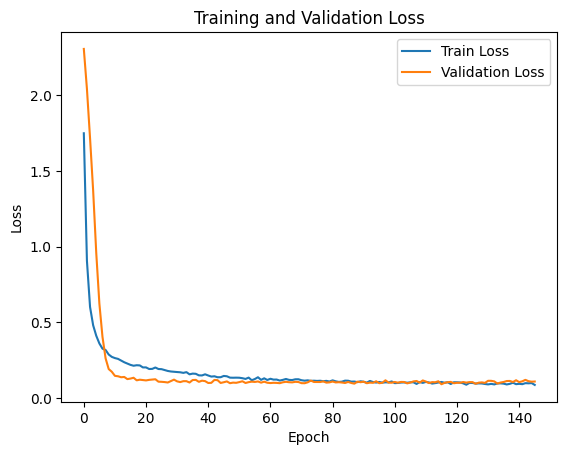

In [147]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [148]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 1ms/step - loss: 0.1104 - accuracy: 0.9700


In [149]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [150]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 56ms/step
[5.27042539e-05 9.86003041e-01 1.38465278e-02 6.12883814e-05
 5.89388037e-06 4.84452471e-07 1.87083278e-05 3.43357613e-07
 9.15827147e-09 1.07042415e-05 4.20337187e-07 1.54364868e-10]
1


# Confusion matrix

In [151]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

<a id="evaluation"></a>

### Evaluation 

94/94 [==============================] - 0s 758us/step


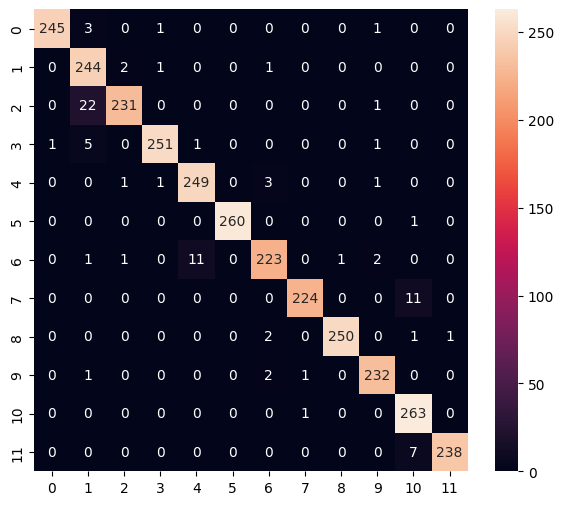

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       250
           1       0.88      0.98      0.93       248
           2       0.98      0.91      0.94       254
           3       0.99      0.97      0.98       259
           4       0.95      0.98      0.97       255
           5       1.00      1.00      1.00       261
           6       0.97      0.93      0.95       239
           7       0.99      0.95      0.97       235
           8       1.00      0.98      0.99       254
           9       0.97      0.98      0.98       236
          10       0.93      1.00      0.96       264
          11       1.00      0.97      0.98       245

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [152]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

## Convert to model for Tensorflow-Lite

In [153]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [154]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\renyi\AppData\Local\Temp\tmpc4lp1yzq\assets


INFO:tensorflow:Assets written to: C:\Users\renyi\AppData\Local\Temp\tmpc4lp1yzq\assets


22848

### Inference test

In [155]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [156]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [157]:
np.array([X_test[0]])

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -9.98144783e-03, -2.23025344e-02,
        -6.88415999e-03, -1.77429337e-02, -4.67161685e-02,
        -1.12438109e-02, -2.39255875e-02, -6.48192242e-02,
        -1.62647236e-02, -3.07960026e-02, -7.62352794e-02,
        -1.95785016e-02,  3.75132959e-17, -6.53303191e-02,
        -4.71468054e-04,  2.75991624e-04, -7.58573189e-02,
        -9.61074326e-03, -3.19577032e-03, -5.69726638e-02,
        -1.42947678e-02, -2.59770849e-03, -5.04614040e-02,
        -1.66317876e-02,  1.11168632e-02, -6.28402531e-02,
        -1.64122332e-03,  1.04519129e-02, -6.97992146e-02,
        -1.06204376e-02,  4.95113898e-03, -4.94120605e-02,
        -1.10188648e-02,  4.78710653e-03, -4.57057171e-02,
        -9.86819528e-03,  2.06429958e-02, -5.75499795e-02,
        -4.91535058e-03,  2.00364944e-02, -6.24663867e-02,
        -1.36479540e-02,  1.37048271e-02, -4.45249192e-02,
        -9.57841892e-03,  1.24939857e-02, -4.03831378e-0

In [158]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.1180422e-05 9.5170462e-01 4.8054218e-02 8.2938561e-05 1.5534060e-05
 1.2602637e-06 8.6062442e-05 6.4471982e-07 2.4838071e-08 2.2502882e-05
 1.0153871e-06 3.5449479e-10]
1
CPU times: total: 0 ns
Wall time: 997 µs
